<a href="https://colab.research.google.com/github/l8518/geot-faas/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [2]:
import datetime

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()

#   Data Analysis

In [5]:
# dataset = pd.read_parquet('dataset-sampled.parquet')
dataset = pd.read_parquet('data/dataset.parquet')

In [6]:
dataset.columns

Index(['driver_invocation', 'workload_invocation', 'provider', 'region',
       'dirty_measurement', 'folder_uuid', '1_run_id', '2_thread_id',
       'SAAFMemoryDeltaError', 'SAAFMemoryError', 'contextSwitches',
       'contextSwitchesDelta', 'cpuIdle', 'cpuIdleDelta', 'cpuIowait',
       'cpuIowaitDelta', 'cpuIrqDelta', 'cpuKrn', 'cpuKrnDelta', 'cpuModel',
       'cpuNice', 'cpuSoftIrq', 'cpuSoftIrqDelta', 'cpuType', 'cpuUsr',
       'cpuUsrDelta', 'endTime', 'frameworkRuntime', 'frameworkRuntimeDeltas',
       'freeMemory', 'functionName', 'latency', 'linuxVersion', 'newcontainer',
       'roundTripTime', 'runtime', 'runtimeOverlap', 'startTime',
       'totalMemory', 'userRuntime', 'uuid', 'vmcpusteal', 'vmcpustealDelta',
       'vmuptime', 'containerID', 'functionMemory', 'pageFaults',
       'pageFaultsDelta', 'vmID', 'dow_utc', 'tod_utc', 'timezone',
       'measure group', 'local_dow', 'local_tod'],
      dtype='object')

In [7]:
# dataset.groupby( ['driver_invocation', 'provider'])['workload_invocation'].nunique()
# dataset.groupby(['local_tod'])['runtime'].agg(['count'])

coefficient_of_variation = lambda x: np.std(x, ddof=1) / np.mean(x) 

## Measurement Errors (TODO)

In [8]:
measure_target = {'AWS': 10 , 'AZURE': 9 , 'GCP': 10}

In [9]:
measurement_df = dataset.groupby(['driver_invocation', 'provider'])['workload_invocation'].nunique().unstack('provider')

<AxesSubplot:>

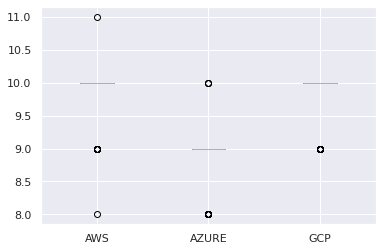

In [10]:
measurement_df.boxplot()

In [11]:
measurement_df[measurement_df['AWS'] > 10]

provider,AWS,AZURE,GCP
driver_invocation,,,
2021-08-04 20:30:04.065,11,9,10


In [12]:
dataset['driver_invocation']

0         2021-08-01 13:30:03.035
1         2021-08-01 13:30:03.035
2         2021-08-01 13:30:03.035
3         2021-08-01 13:30:03.035
4         2021-08-01 13:30:03.035
                    ...          
6130544   2021-08-08 23:30:03.447
6130545   2021-08-08 23:30:03.447
6130546   2021-08-08 23:30:03.447
6130547   2021-08-08 23:30:03.447
6130548   2021-08-08 23:30:03.447
Name: driver_invocation, Length: 6130549, dtype: datetime64[ns]

## Provider Differences

### Runtime

In [ ]:
cov_provider_df = dataset.groupby( ['provider'])['runtime'].apply(coefficient_of_variation).dropna().reset_index(name='Runtime CV').set_index(['provider'])
mean_provider_df = dataset.groupby( ['provider'])['runtime'].mean().dropna().reset_index(name='Runtime Mean').set_index(['provider'])

In [ ]:
matplotlib.style.use('seaborn-colorblind')
# Plot Coefficient Of Variation Per Cloud Provider:
fig, axes = plt.subplots(figsize=(8,6), ncols=2, nrows=1, frameon=False, sharex=True)

# mean_provider_df.plot(kind='bar', ax=axes[0])
# axes[0].set_xlabel('')
# axes[0].title.set_text('Runtime Mean')
# axes[0].get_legend().remove()

cov_provider_df.plot(kind='bar', ax=axes[0])
#axes[0].title.set_text('Runtime CV')
axes[0].set_xlabel('')
axes[0].set_ylabel('Runtime CV')
axes[0].get_legend().remove()

gs = axes[1].get_gridspec()
axes[1].remove()
# axes[2].remove()
# axes[3].remove()
axbig = fig.add_subplot(gs[1:])

dataset[['provider', 'runtime']].sort_values(by=['provider']).groupby(['provider'], observed=True).boxplot(subplots=False, ax=axbig, showfliers=False)

labels = []
for tick in axbig.get_xticklabels():
  provider = tick.get_text()[1:].split(',')[0]
  labels.append(f"{provider}")
axbig.set_xticklabels(labels)
axbig.set_ylabel('Runtime\nBoxplots')

# Fix Label Rotation
plt.setp(axbig.get_xticklabels(), rotation=0)
plt.setp(axes[0].get_xticklabels(), rotation=0)

fig.tight_layout()

plt.savefig('provider_mean_cov.pdf')
plt.show()
plt.close()
print(dataset[['provider', 'runtime']].groupby(['provider'], observed=True).describe())

### Container Ids

In [ ]:
uuid_unique_count_df = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

In [ ]:
uuid_unique_count_df[['provider', 'Unique Container Id']].groupby(['provider'], observed=True).boxplot(figsize=(14,10), subplots=False)
print(uuid_unique_count_df[['provider', 'Unique Container Id']].groupby(['provider'], observed=True).describe())

### CPUs

In [ ]:
dataset[['provider', 'cpuModel', 'cpuType']].drop_duplicates()

In [ ]:
provider_cpus_df = dataset.groupby(['provider'], observed=True)['cpuType'].nunique()
provider_cpus_df.groupby(['provider']).describe()

In [ ]:
cpu_count_df = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index(name='Unique CPU Types')

In [ ]:
print('Average CPU Types used per Invocation')
cpu_count_df.groupby(['provider']).boxplot(subplots=False, rot=45)
print(cpu_count_df.groupby(['provider']).describe())

Double Schedule + Missing Measurements

## Regional Provider Differences

In [ ]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = dataset.groupby( ['provider', 'region'], observed=True)['measure_group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
  for measure_group in row['measure_group']:
    region = row['region']
    provider = row['provider']
    measure_group = row['measure_group'][0]
    provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure_group': measure_group, 'provider': provider}
    provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure_group': measure_group, 'provider': provider}

### Runtime Mean and CV

In [ ]:
measure_group_df = dataset.groupby(['provider', 'region'], observed=True)['measure_group'].unique().dropna().reset_index()

In [ ]:
cov_provider_region_df = dataset.groupby( ['measure_group', 'provider', 'region'], observed=True)['runtime'].apply(coefficient_of_variation).reset_index(name='Runtime CV').set_index(['provider', 'region'])
# mean_provider_region_df = dataset.groupby( ['measure_group', 'provider', 'region'], observed=True)['runtime'].mean().reset_index(name='Runtime Mean').set_index(['provider', 'region'])

In [ ]:
# mean_provider_region_df.sort_values(by=['measure_group', 'provider', 'region'])
cov_provider_region_df.sort_values(by=['measure_group', 'provider', 'region'])

for provider in cov_provider_region_df.index.get_level_values('provider').unique():
  fig, axes = plt.subplots(figsize=(10,6), nrows=2, frameon=False)

  #mean_provider_region_df[cov_provider_region_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[0])
  dataset[['provider', 'region', 'runtime']][dataset['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes[0], showfliers=False)

  cov_provider_region_df[cov_provider_region_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[1])

  axes[0].set_ylabel('Runtime\n Boxplots')
  # axes[0].get_legend().remove()
  labels = []
  for tick in axes[0].get_xticklabels():
    labels.append('')
  axes[0].set_xticklabels(labels)

  for tick in axes[1].get_xticklabels():
    tick.set_rotation(50)
  
  # Set Region Names
  labels = []
  for tick in axes[1].get_xticklabels():
    mapping = provider_region_mapping[tick.get_text()]
    region = mapping['region']
    measure_group = mapping['measure_group']
    labels.append(f"{measure_group}\n({region})")
  
  axes[1].get_legend().remove()
  axes[1].set_ylabel('Runtime \n CV')
  axes[1].set_xticklabels(labels)
  axes[1].set_xlabel('')


  fig.tight_layout()

  print(provider)
  plt.savefig(f'provider_region_mean_cov_{provider}.pdf')
  plt.show()
  plt.close()

  # Generate a control figure - because I cannot fore the matching
  fig, axes = plt.subplots(figsize=(12,10))
  dataset[['provider', 'region', 'runtime']][dataset['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
  plt.savefig(f'provider_region_mean_cov_{provider}_box.pdf')
  plt.show()
  plt.close()

### Container Ids

In [ ]:
uuid_unique_count_df = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

In [ ]:
uuid_unique_count_grouped = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

In [ ]:
uuid_mean_unique_count_df = uuid_unique_count_df.groupby(['measure_group', 'provider', 'region'], observed=True)['Unique Container Id'].mean().reset_index(name='Mean Unique Container Id').set_index(['provider', 'region'])
uuid_cv_unique_count_df = uuid_unique_count_df.groupby(['measure_group', 'provider', 'region'], observed=True)['Unique Container Id'].apply(coefficient_of_variation).reset_index(name='CV Unique Container Id').set_index(['provider', 'region'])

In [ ]:
uuid_mean_unique_count_df.sort_values(by=['measure_group', 'provider', 'region'])
uuid_cv_unique_count_df.sort_values(by=['measure_group', 'provider', 'region'])

for provider in uuid_cv_unique_count_df.index.get_level_values('provider').unique():
  fig, axes = plt.subplots(figsize=(10,6), nrows=2, frameon=False)

  # fig.add_subplot(axsub)
  uuid_unique_count_grouped[uuid_unique_count_grouped['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes[0], showfliers=False)
  uuid_cv_unique_count_df[uuid_cv_unique_count_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[1])

  axes[0].set_ylabel('Container Id\nUnique Count\n Boxplot')
  labels = []
  for tick in axes[0].get_xticklabels():
    labels.append('')
  axes[0].set_xticklabels(labels)

  # axes[0].get_legend().remove()

  for tick in axes[1].get_xticklabels():
    tick.set_rotation(50)
  
  # Set Region Names
  labels = []
  for tick in axes[1].get_xticklabels():
    mapping = provider_region_mapping[tick.get_text()]
    region = mapping['region']
    measure_group = mapping['measure_group']
    labels.append(f"{measure_group}\n({region})")
  
  axes[1].get_legend().remove()
  axes[1].set_ylabel('Container Id\nUnique Count\n CV')
  axes[1].set_xticklabels(labels)
  axes[1].set_xlabel('')


  fig.tight_layout()

  plt.savefig(f'provider_region_container_ids_{provider}.pdf')
  plt.show()
  plt.close()

  # Generate a control figure - because I cannot fore the matching
  fig, axes = plt.subplots(figsize=(10,6))
  uuid_unique_count_grouped[uuid_unique_count_grouped['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
  plt.savefig(f'provider_region_container_ids_{provider}_box.pdf')
  plt.show()
  plt.close()

### CPU types

In [ ]:
unique_cpu_types_df = dataset.groupby(['measure_group', 'provider', 'region'], observed=True)['cpuType'].unique()
unique_cpu_types_df.to_csv('unique_cpu_types_region_provider', index=False)
unique_cpu_types_df

In [ ]:
unique_cpu_types_count_df = dataset.groupby(['measure_group', 'provider', 'region'], observed=True)['cpuType'].nunique()
unique_cpu_types_count_df

In [ ]:
unique_cpu_types_count_per_invocation_df = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index()
unique_cpu_types_count_per_invocation_df.groupby(['provider', 'region']).describe()

In [ ]:
# Boxplots over CPUs per Invocation
for provider in unique_cpu_types_count_per_invocation_df['provider'].unique():
  fig, axes = plt.subplots(figsize=(6,3), nrows=1, ncols=1, frameon=False)
  unique_cpu_types_count_per_invocation_df[unique_cpu_types_count_per_invocation_df['provider'] == provider].groupby('region', observed=True).boxplot(subplots=False, rot=45, ax=axes)
  plt.savefig(f'unique_cpu_types_count_per_invocation_{provider}_box.pdf')
  plt.show()
  plt.close()

### Correlation Stuff - is that even possible?!

In [ ]:
regional_provider_differences = dataset[ ['provider', 'region', 'runtime', 'driver_invocation'] ]
regional_provider_differences_avg_runtime = regional_provider_differences.groupby(['provider', 'region', 'driver_invocation'],observed=True).mean().reset_index()

In [ ]:
regional_provider_differences_avg_runtime

In [ ]:
region_dummies = pd.get_dummies(regional_provider_differences_avg_runtime, prefix=['region'], columns=['region'])

In [ ]:
region_dummies

In [ ]:
df = pd.concat( [regional_provider_differences_avg_runtime, region_dummies] , axis=1)
df

In [ ]:
df.corr()

In [ ]:
regional_provider_differences_avg_runtime.corr()

In [ ]:
# pd.crosstab(regional_provider_differences_avg_runtime.index.get_level_values('region'), regional_provider_differences_avg_runtime['runtime'])

## Regional Differences - TODO: Integrate other stuff

In [ ]:
cov_regional_df = dataset.groupby( ['measure_group', 'provider', 'region'], observed=True)['runtime'].apply(coefficient_of_variation).reset_index(name='Runtime CV').set_index(['provider', 'region', 'measure_group'])
cov_regional_df = cov_regional_df.sort_values(by=['measure_group', 'provider', 'region'])

In [ ]:
dataset = dataset.sort_values(by=['measure_group', 'provider', 'region'])

for measure_group in cov_regional_df.index.get_level_values('measure_group').unique():
  fig, axes = plt.subplots(figsize=(12,8), nrows=4, ncols=2, frameon=False)

  gs = axes[0, 0].get_gridspec()
  axes[0, 0].remove()
  axes[1, 0].remove()
  axes[2, 0].remove()
  axbig = fig.add_subplot(gs[:3, 0])

  cov_regional_df[cov_regional_df.index.isin([measure_group], level='measure_group')].plot(kind='bar', ax=axes[3, 0])
  dataset[['measure_group', 'provider', 'region', 'runtime']][dataset['measure_group'] == measure_group].groupby(['measure_group', 'region', 'provider'], observed=True).boxplot(subplots=False, ax=axbig, showfliers=False)

  axbig.get_xaxis().set_ticks([])

  axbig.set_ylabel('Runtime\n Boxplots')

  # Set Region Names
  labels = []
  for tick in axes[3, 0].get_xticklabels():
    mapping = provider_region_mapping[tick.get_text()]
    labels.append(f"{mapping['provider']}\n({mapping['region']})")

  axes[3, 0].get_legend().remove()
  axes[3, 0].set_ylabel('Runtime \n CV')
  axes[3, 0].set_xticklabels(labels)
  axes[3, 0].set_xlabel('')
  for tick in axes[3, 0].get_xticklabels():
    tick.set_rotation(50)

  fig.tight_layout()

  print(measure_group)
  plt.savefig(f'cov_regional_cov_boxplot_{measure_group}.pdf')
  plt.show()
  plt.close()

  # # Generate a control figure - to check if correct
  fig, axes = plt.subplots(figsize=(12,10))
  dataset[['measure_group', 'provider', 'region', 'runtime']][dataset['measure_group'] == measure_group].groupby(['measure_group', 'region', 'provider'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
  plt.savefig(f'cov_regional_cov_boxplot_{measure_group}_control.pdf')
  plt.show()
  plt.close()

# Other Stuff (Experimental)

In [ ]:
dataset

In [ ]:
fig, axes = plt.subplots(figsize=(30,18), nrows=3, ncols=1, sharey='all')
dataset[dataset['provider'] == 'AWS'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes[0])
dataset[dataset['provider'] == 'AZURE'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes[1])
dataset[dataset['provider'] == 'GCP'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes[2])

fig.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(figsize=(30,6))
dataset[dataset['provider'] == 'AWS'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes)
fig.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(figsize=(30,6))
dataset[dataset['provider'] == 'AZURE'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes)
fig.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(figsize=(30,6))
dataset[dataset['provider'] == 'GCP'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes)
fig.tight_layout()
plt.show()
plt.close()

In [ ]:
provider_regions_df = dataset[['provider', 'region']].value_counts().reset_index(name='count')

In [ ]:
def plot_mean_col(dataset, provider, region, col):
    provider_df = dataset[dataset['provider'] == provider]
    provider_region_df = provider_df[provider_df['region'] == region]
    mean_latency_df = provider_region_df.groupby(['driver_invocation'])[col].mean()
    
    fig, ax = plt.subplots(figsize=(220,6))
    mean_latency_df.plot(title=f'{provider} {region} mean {col}', style='.-')

    hours = mdates.MinuteLocator(byminute=[0,30]) #or use interval

    hours.MAXTICKS = 3392

    h_fmt = mdates.DateFormatter('%a %H')


    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)

    fig.autofmt_xdate()

    plt.xticks(rotation=90)
    plt.savefig(f'plot_mean_col_long_{provider}_{region}_{col}.pdf')
    plt.show()
    plt.close()

In [ ]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

def plot(indexrowpair):
    index = indexrowpair[0]
    row = indexrowpair[1]
    provider = row['provider']
    region =  row['region']
    df = dataset[['provider', 'region', 'latency', 'runtime', 'driver_invocation']] #.copy()
    plot_mean_col(df, provider, region, 'latency')
    plot_mean_col(df, provider, region, 'runtime')
    
   
# with ThreadPoolExecutor(max_workers=32) as executor:
#    result = executor.map(plot, provider_regions_df.iterrows())
#    print(list(result))

for irp in provider_regions_df.iterrows():
     plot(irp)

In [6]:
unique_cpu_models = dataset.groupby(['provider'])['cpuModel'].nunique()
unique_vendors = dataset.groupby(['provider'])['vendorId'].nunique()

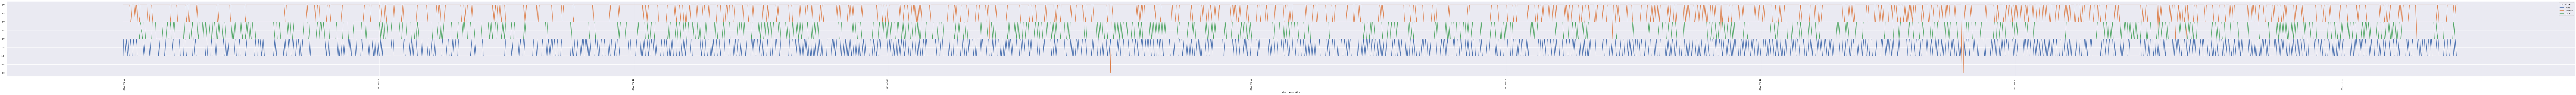

In [7]:
fig, ax = plt.subplots(figsize=(240,8))
dataset.groupby(['driver_invocation', 'provider'])['cpuType'].nunique().unstack().plot(ax=ax, kind='line')

plt.xticks(rotation=90)
plt.show()
plt.close()

In [8]:
region = 'sa-east-1'
provider = 'AWS'

In [9]:
# for mg in measure_groups:
#   for provider in measure_groups[mg]['providers']:
#     regions = measure_groups[mg]['providers'][provider]
#     if len(regions) > 0:
      
#       for region in regions:
#         fig, ax = plt.subplots(figsize=(12,8))
#         df = dataset[ (dataset['region'] == region) & (dataset['provider'] == provider)]
#         df.groupby(['local_dow'])['runtime'].agg(['mean', 'std']).loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot(title=f'{mg} - {provider} Mean with Std, {region}', kind='bar', yerr='std', ax=ax)

#         plt.show()
#         plt.close()

NameError: name 'measure_groups' is not defined

In [ ]:
# mgs = measure_groups.keys()
# for mg in mgs:
#   for provider in measure_groups[mg]['providers']:
#     regions = measure_groups[mg]['providers'][provider]
#     if len(regions) > 0:
      
#       for region in regions:
#         fig, ax = plt.subplots(figsize=(24,8))
#         df = dataset[ (dataset['region'] == region) & (dataset['provider'] == provider)]
#         df.groupby(['local_tod'])['runtime'].agg(['mean', 'std']).plot(title=f'{mg} - {provider} Mean with Std, {region}', kind='bar', yerr='std', ax=ax)
#         plt.show()
#         plt.close()

In [10]:
def get_average_responses_per_region_and_local_tod(dataset):
  df = dataset.groupby(['region', 'local_tod'])[ ['driver_invocation'] ].agg(['count', 'nunique'])
  return (df[ ('driver_invocation', 'count') ] / df[ ('driver_invocation', 'nunique') ]).reset_index(name ='Average Responses')
avg_reponses_df = get_average_responses_per_region_and_local_tod(dataset)
avg_reponses_df = avg_reponses_df.set_index('local_tod')

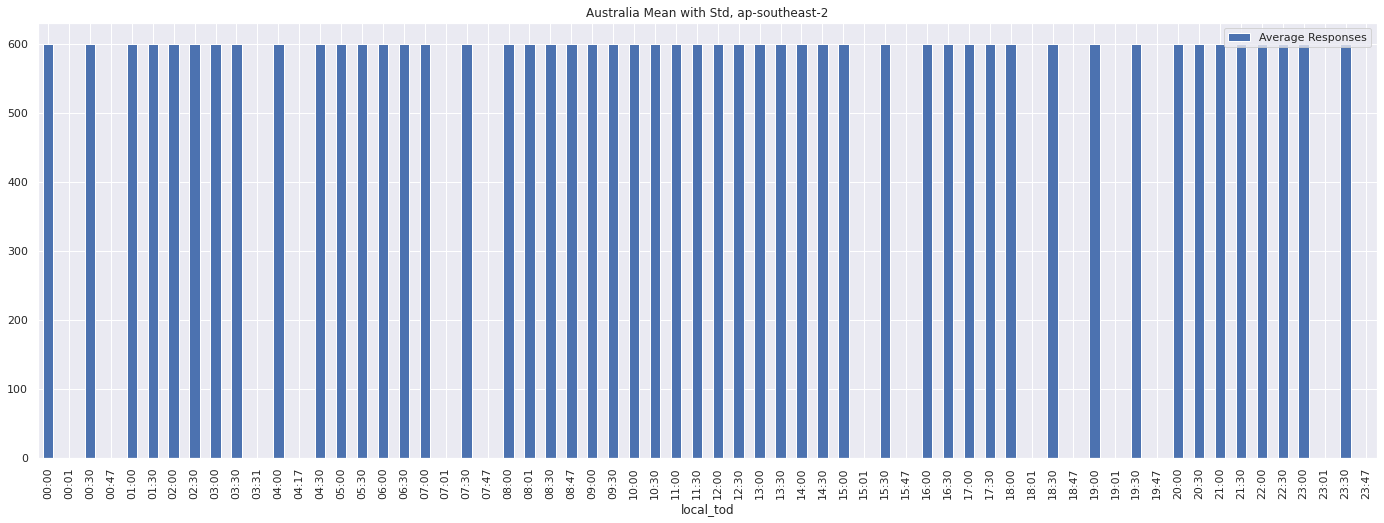

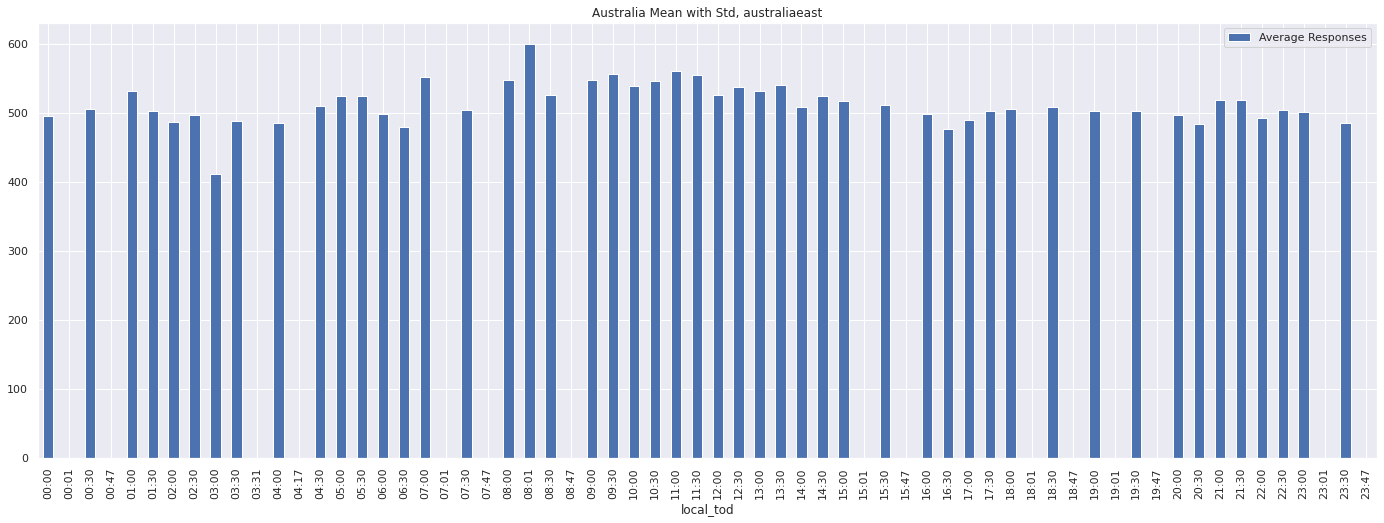

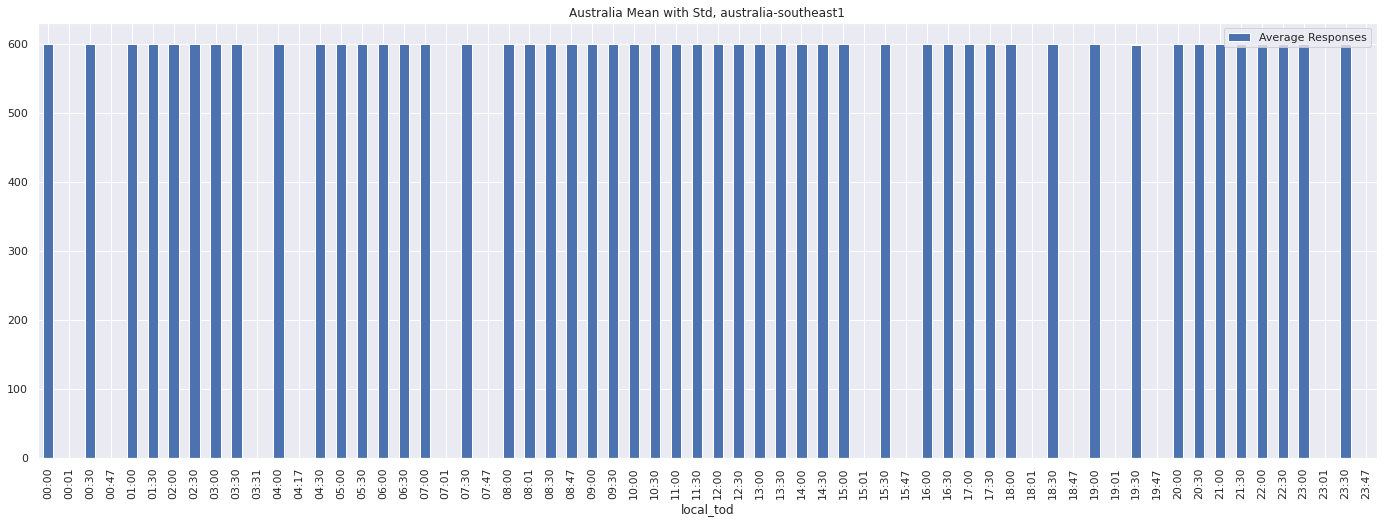

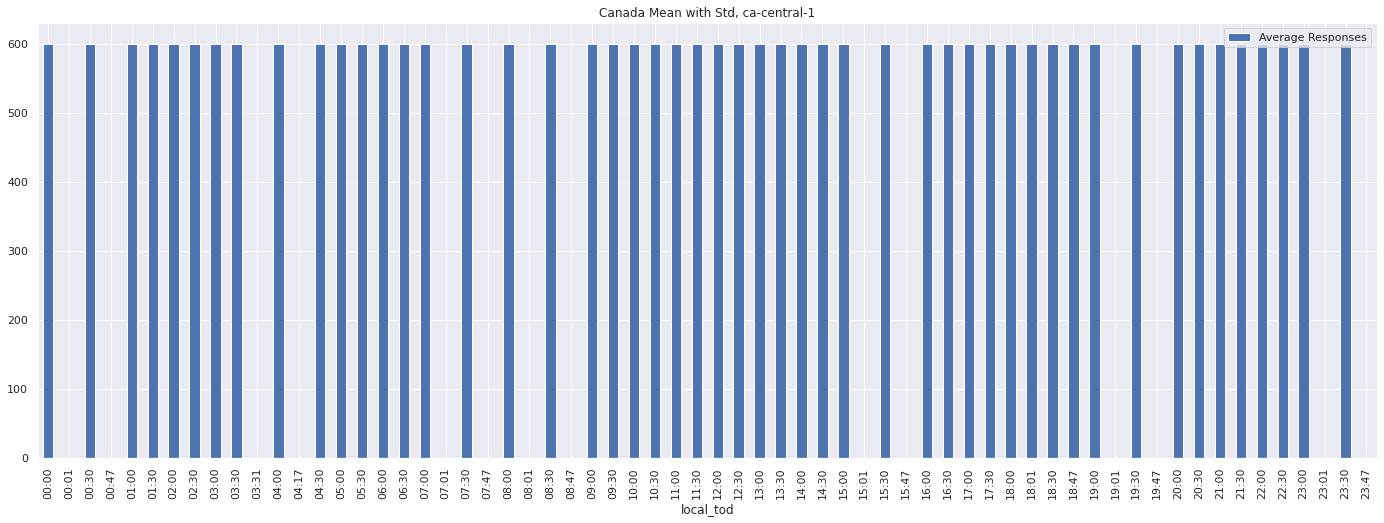

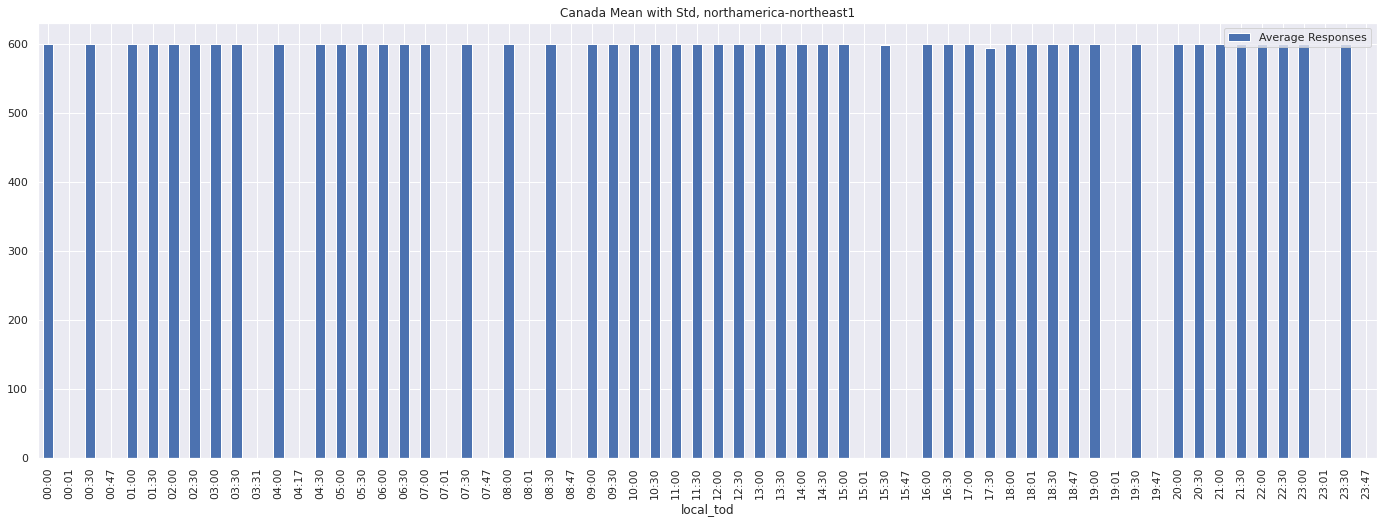

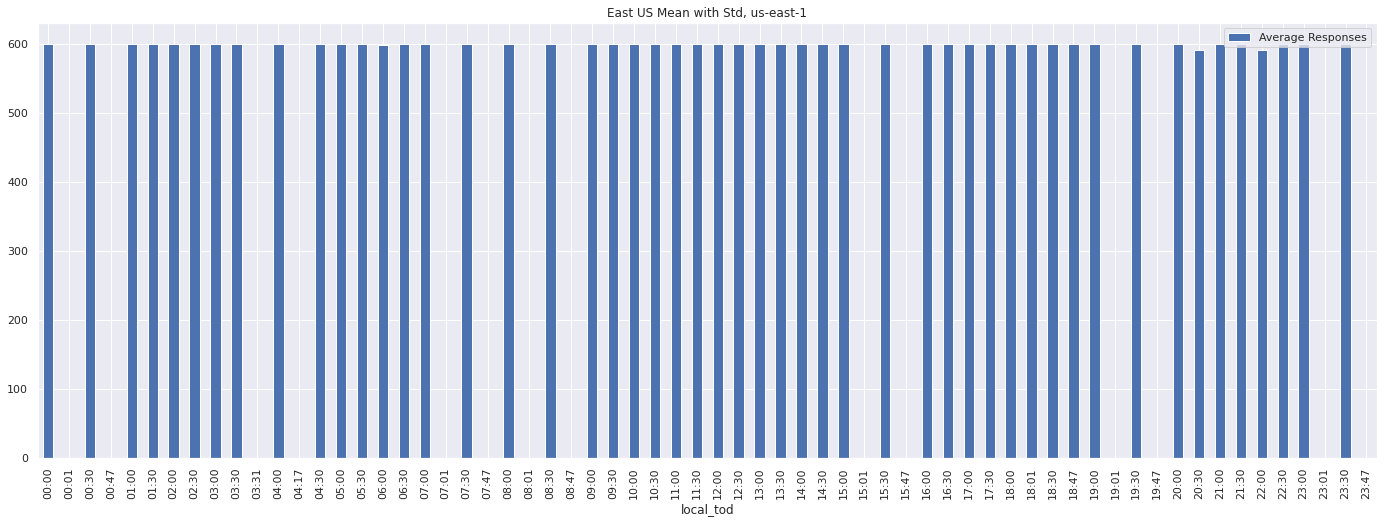

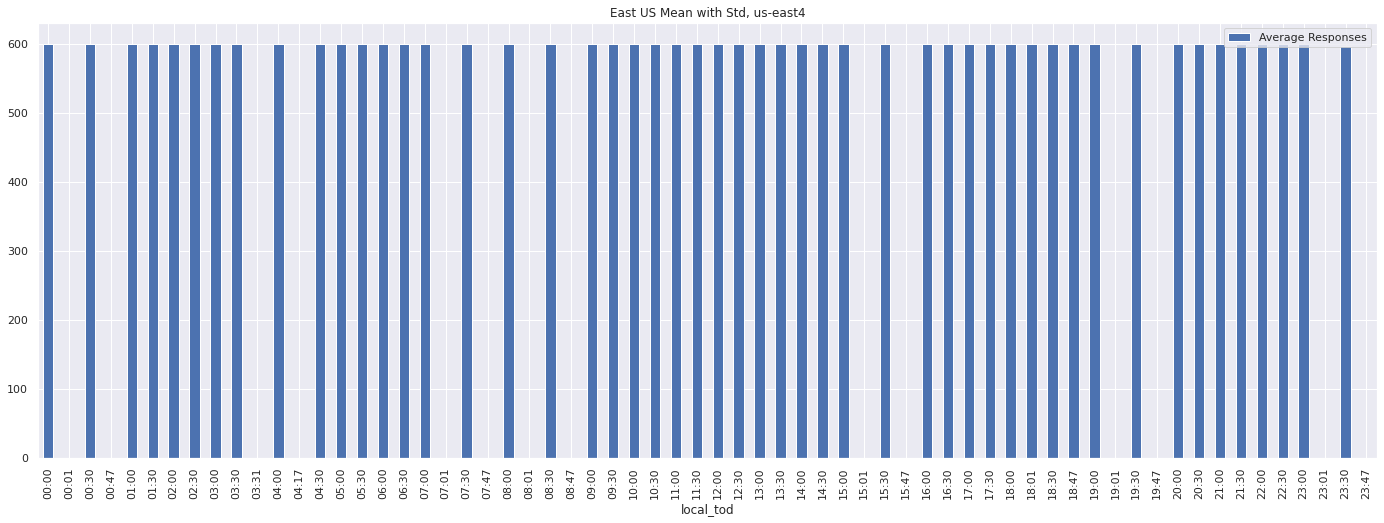

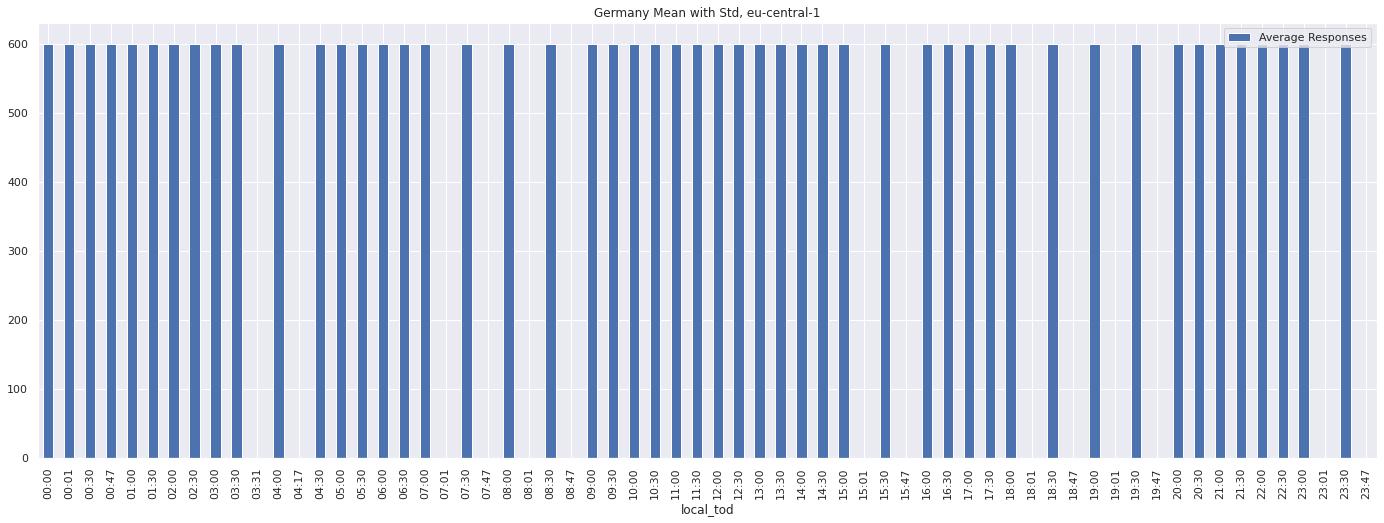

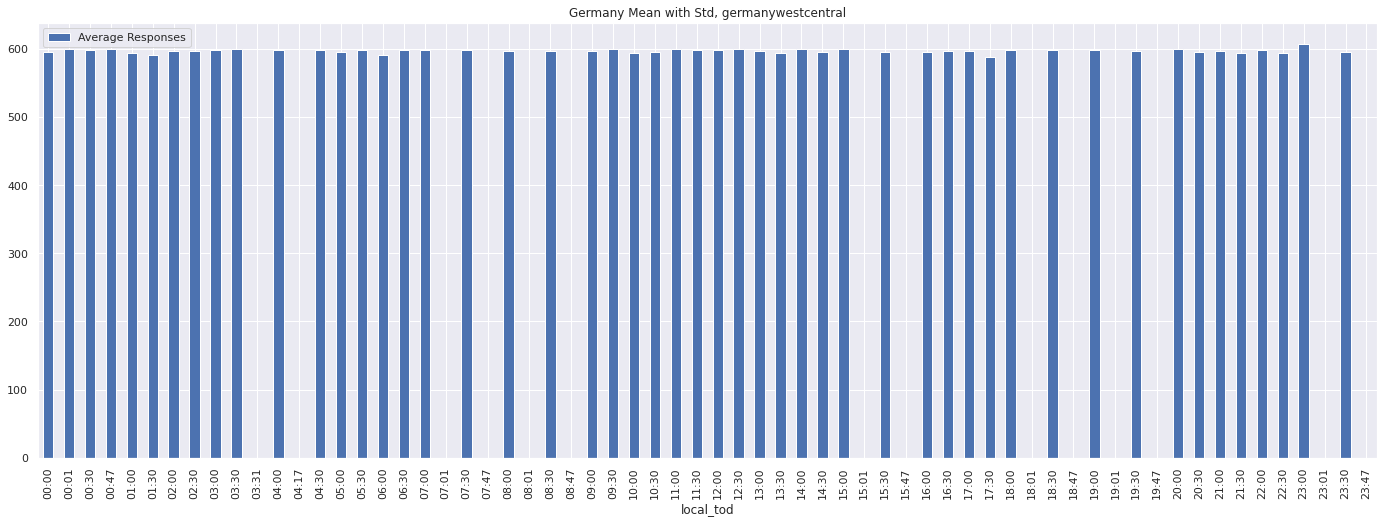

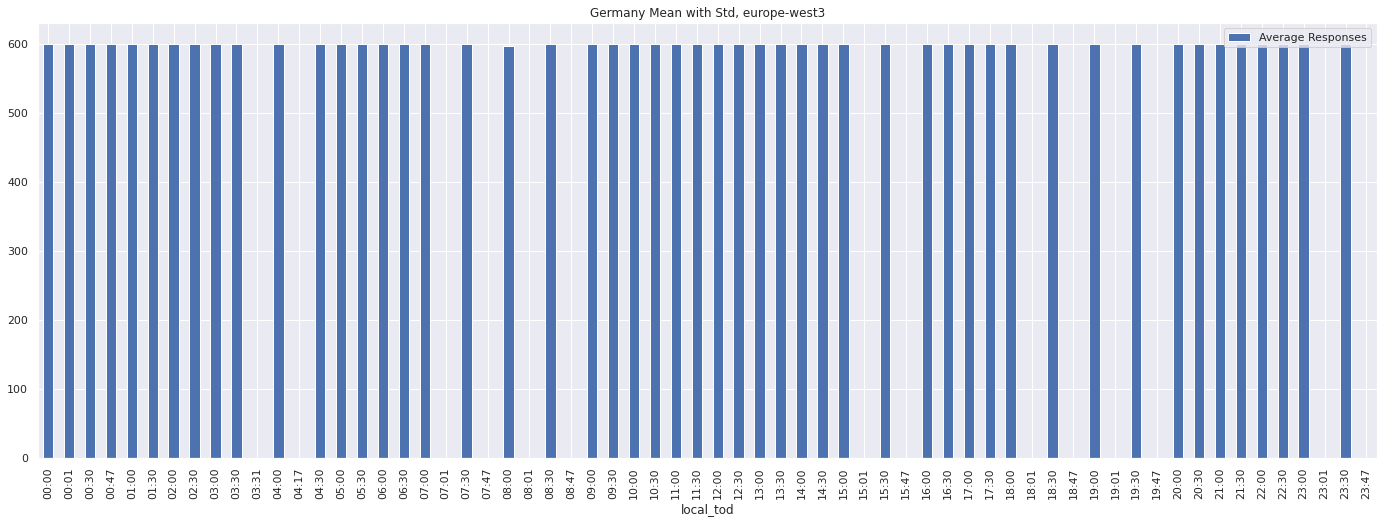

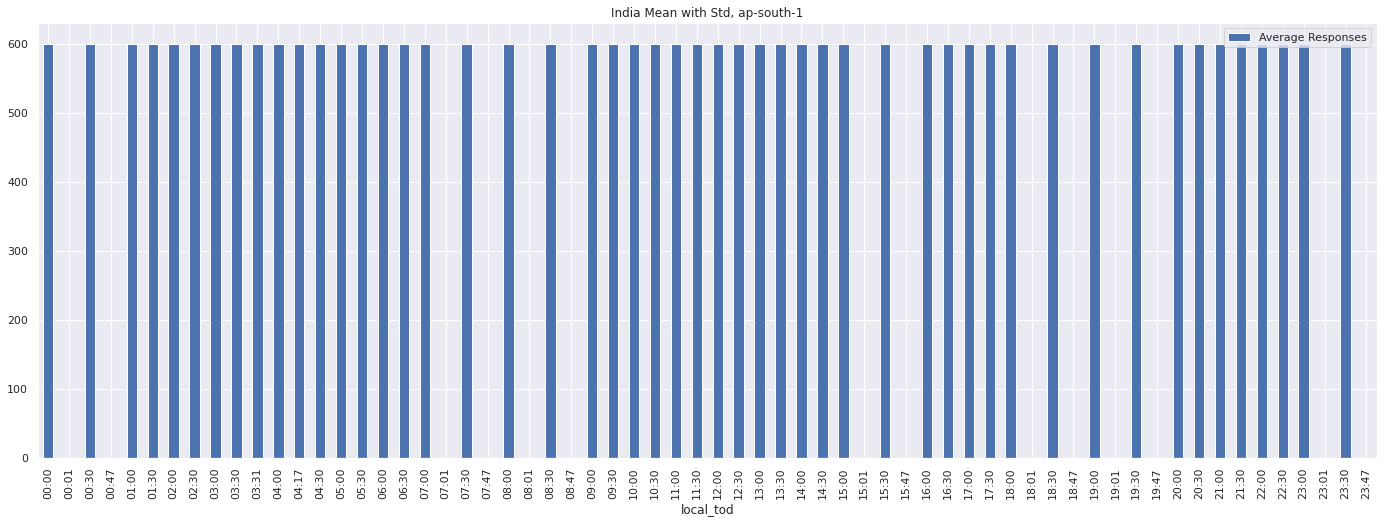

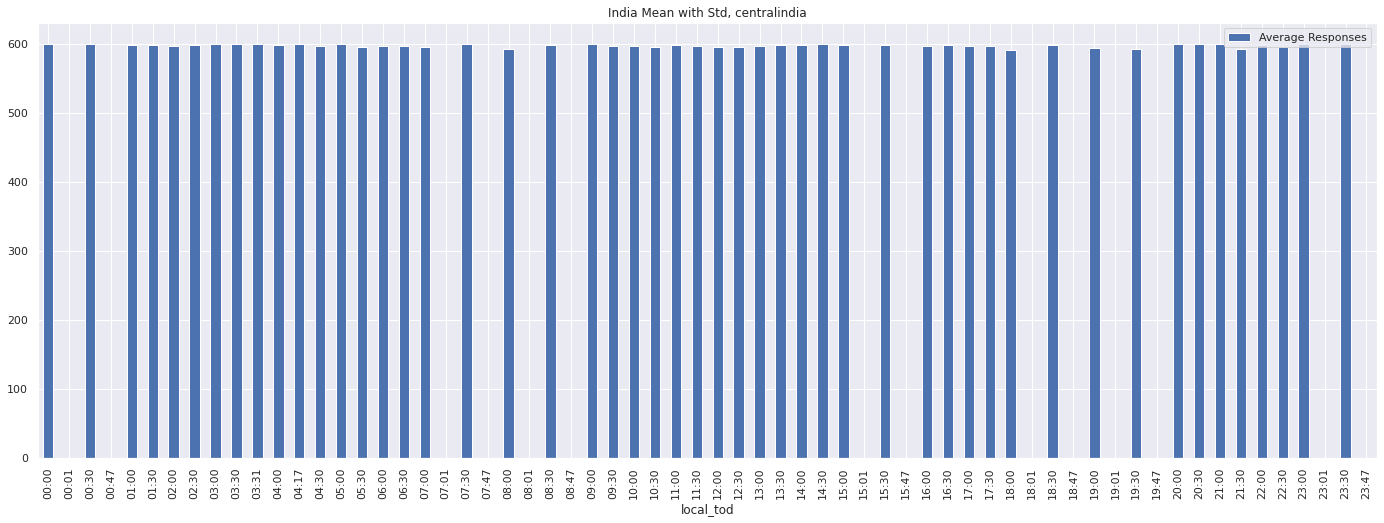

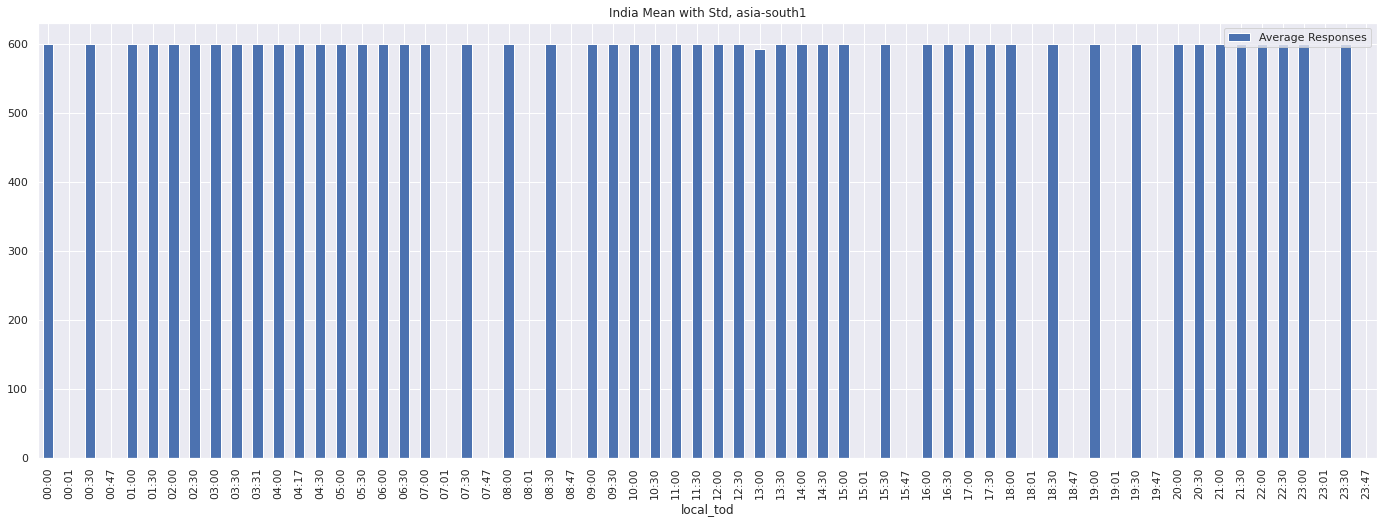

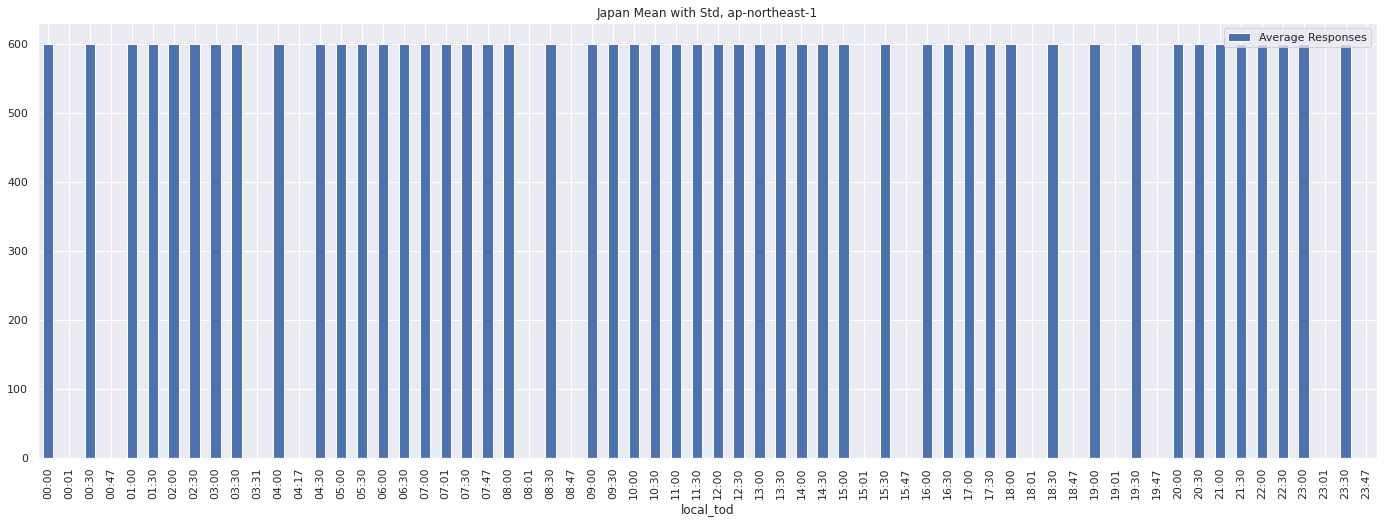

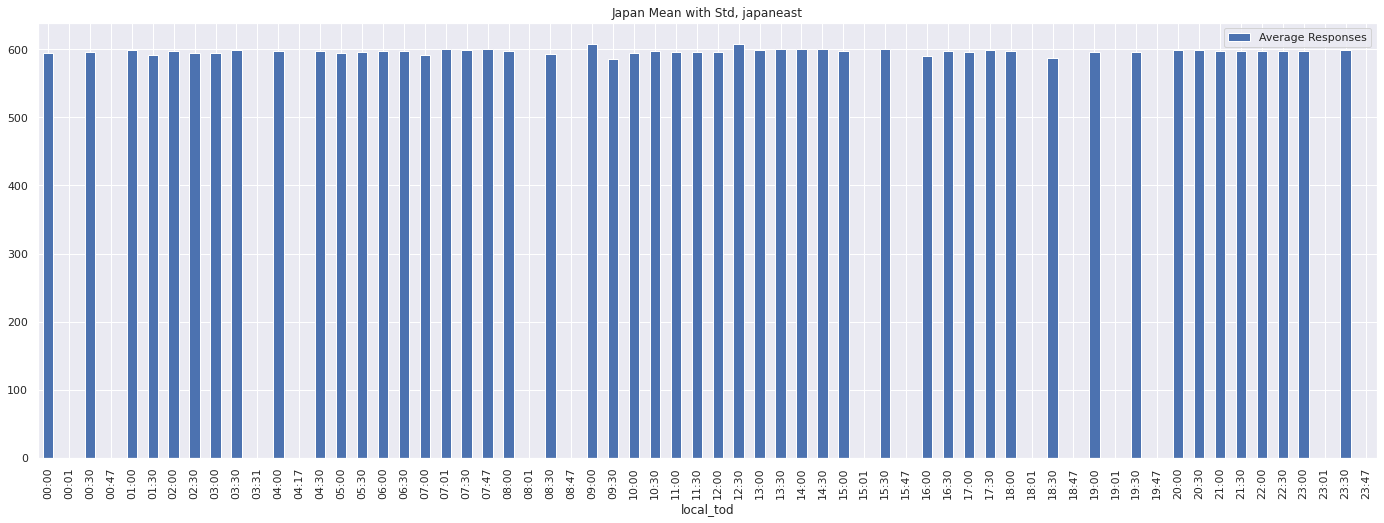

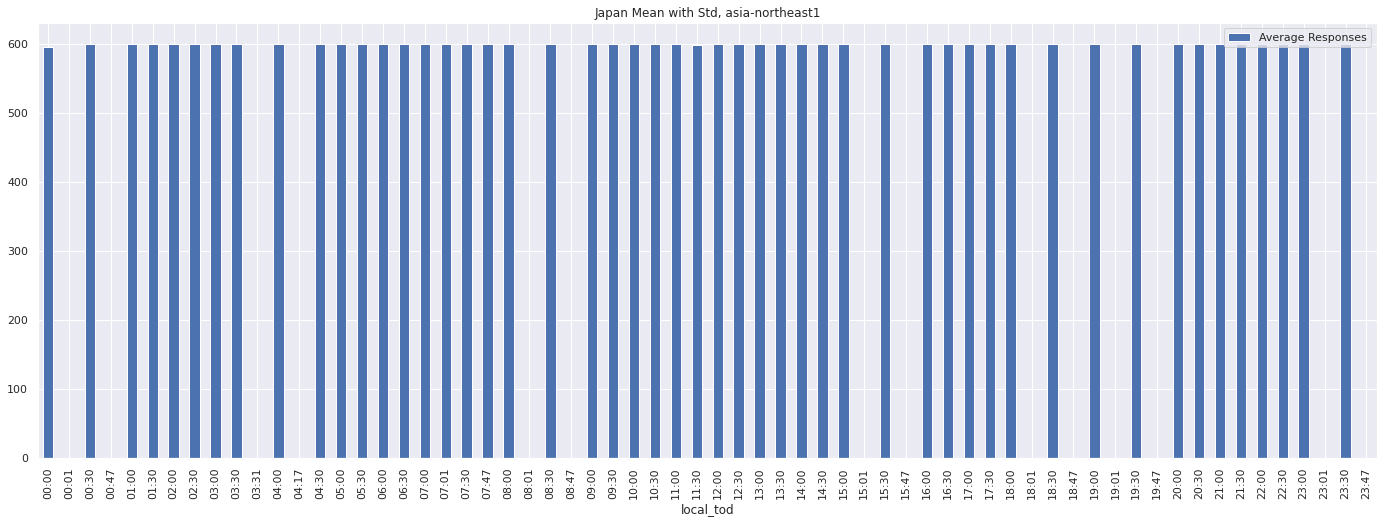

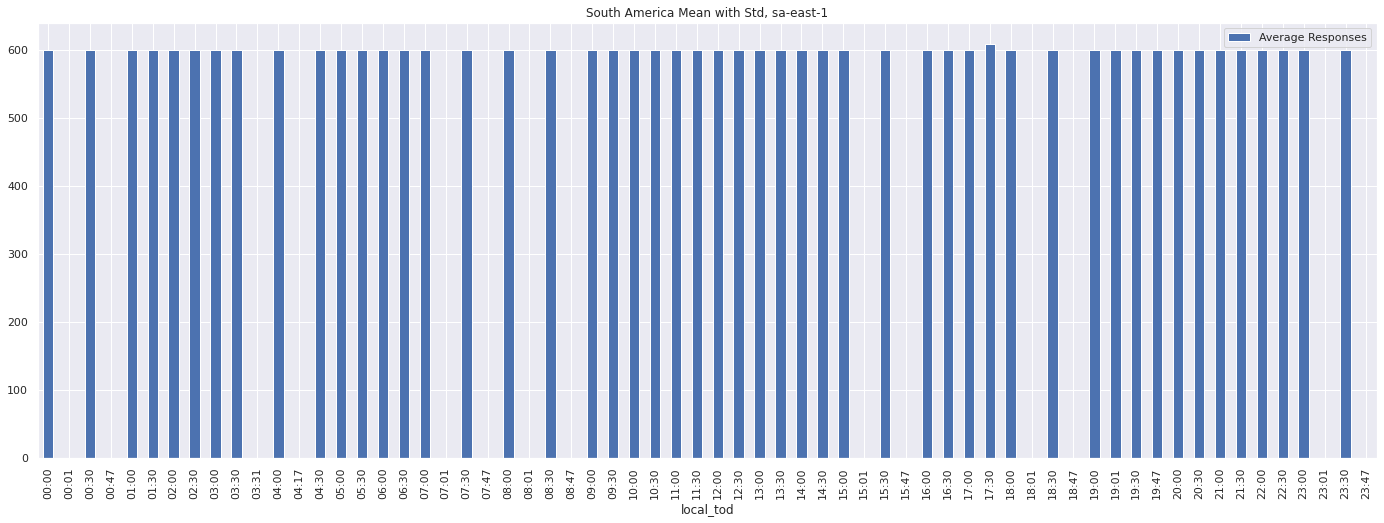

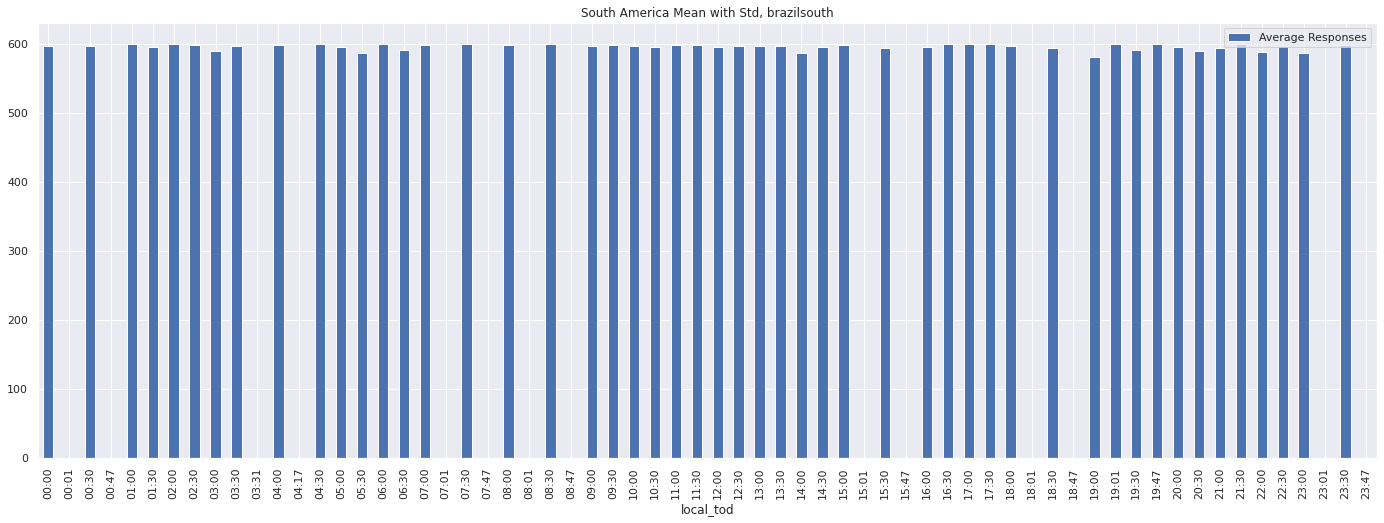

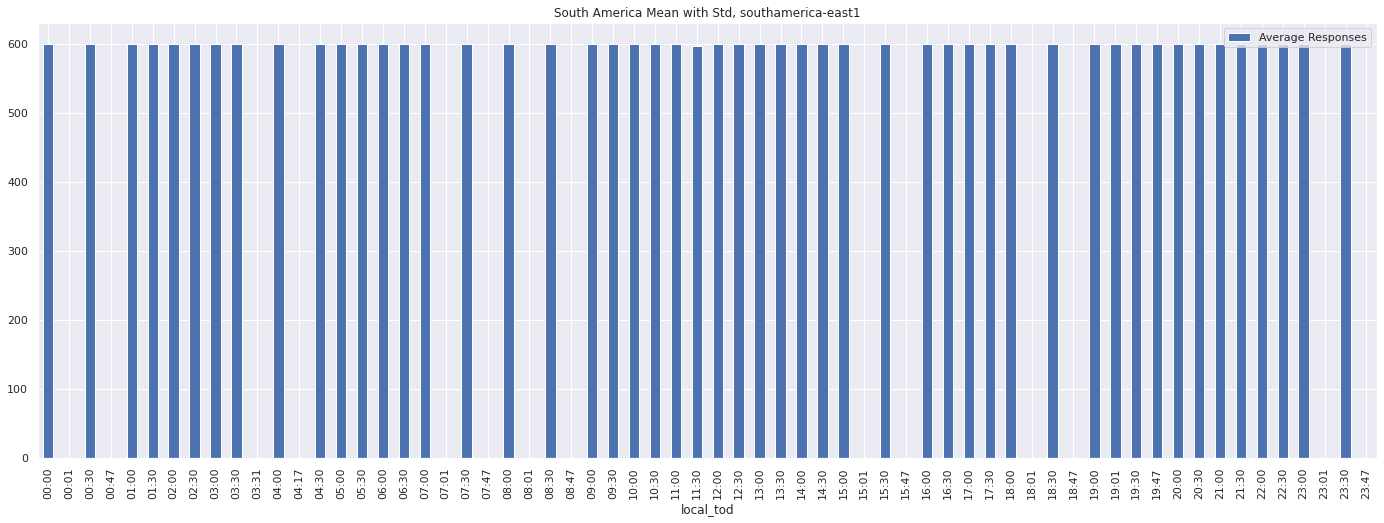

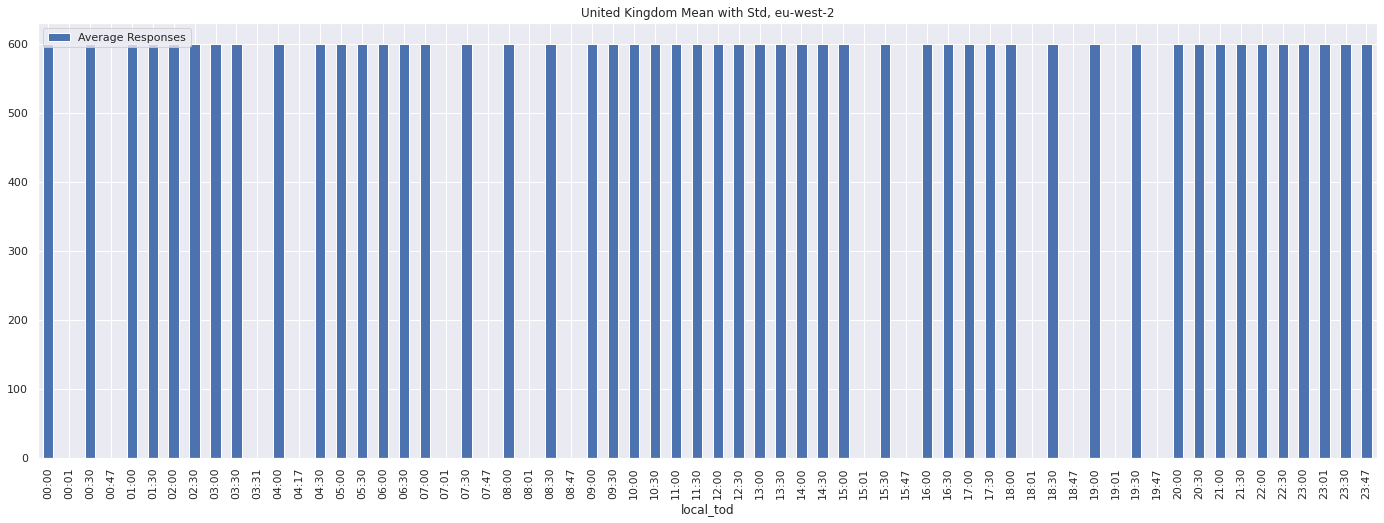

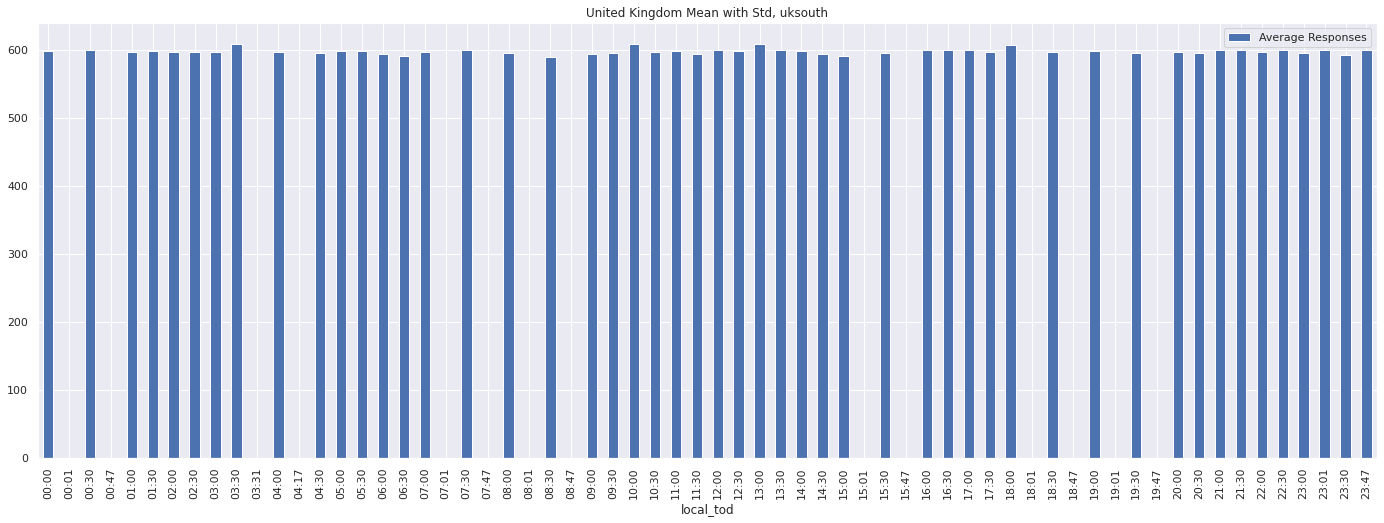

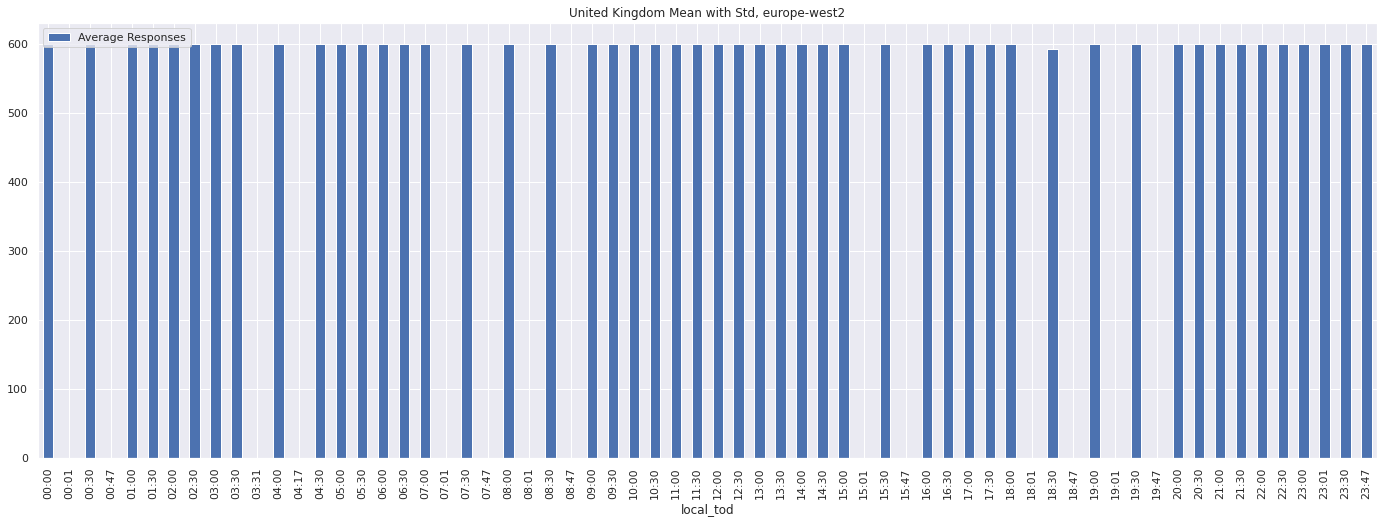

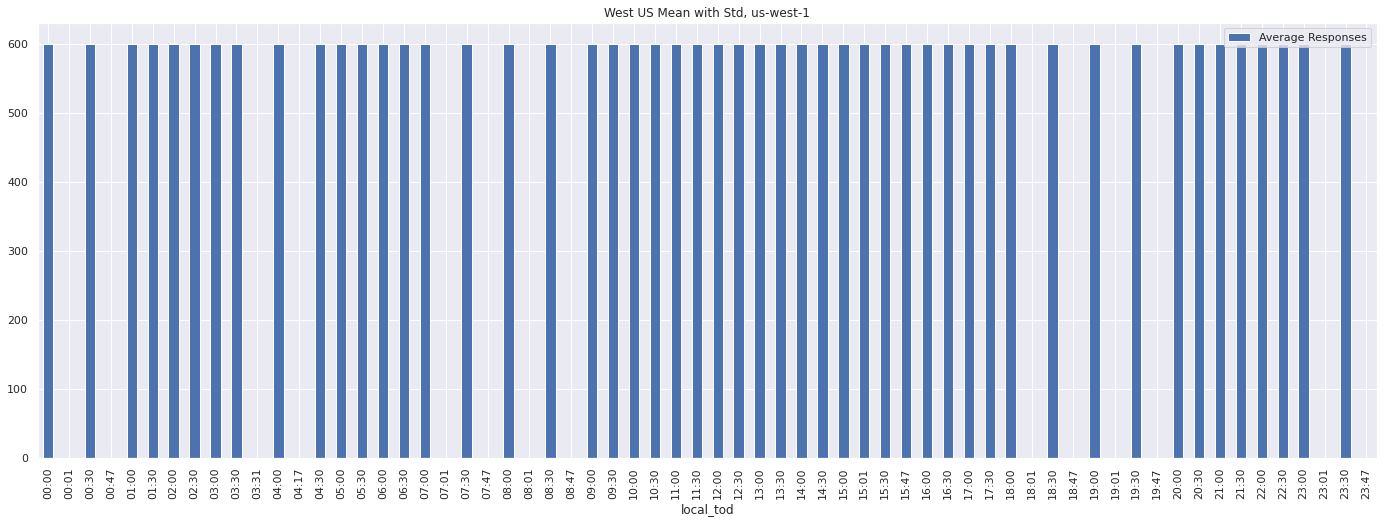

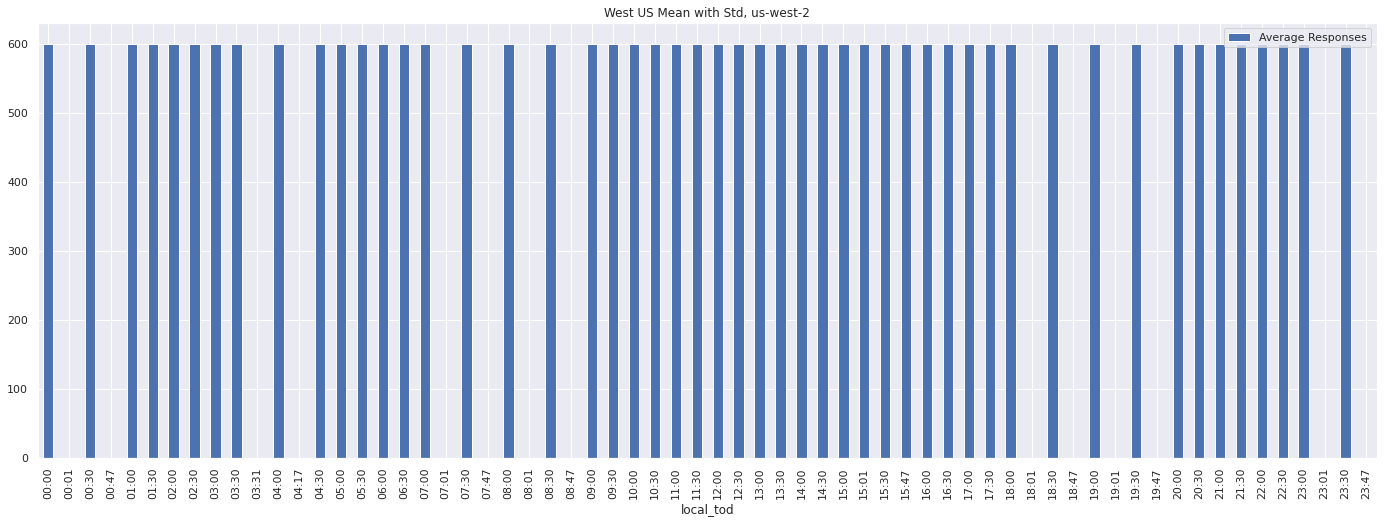

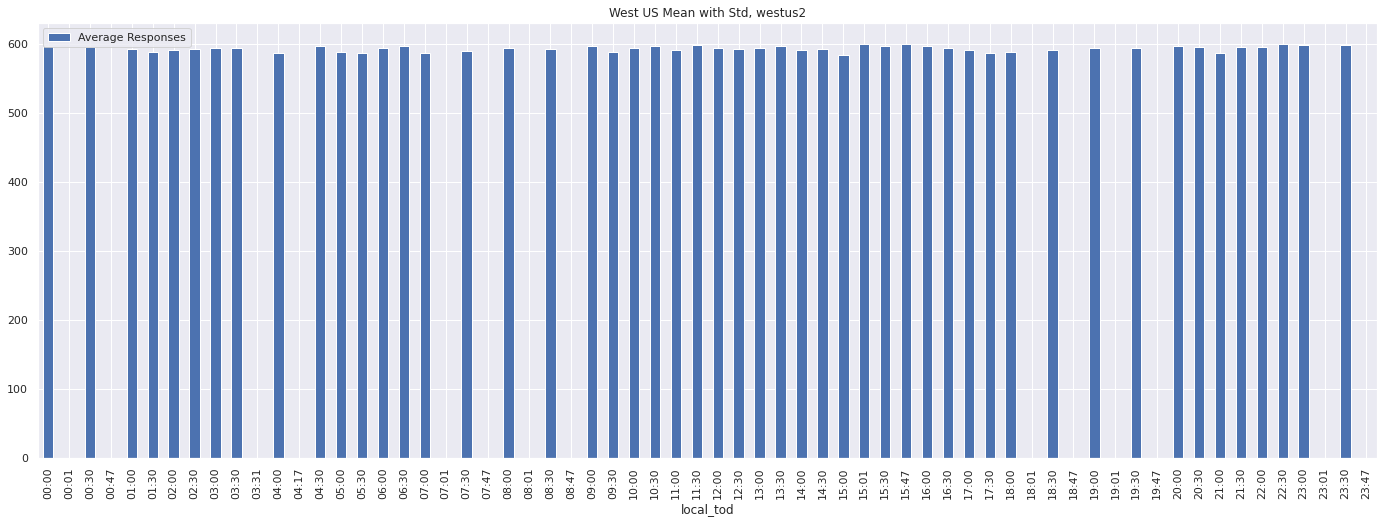

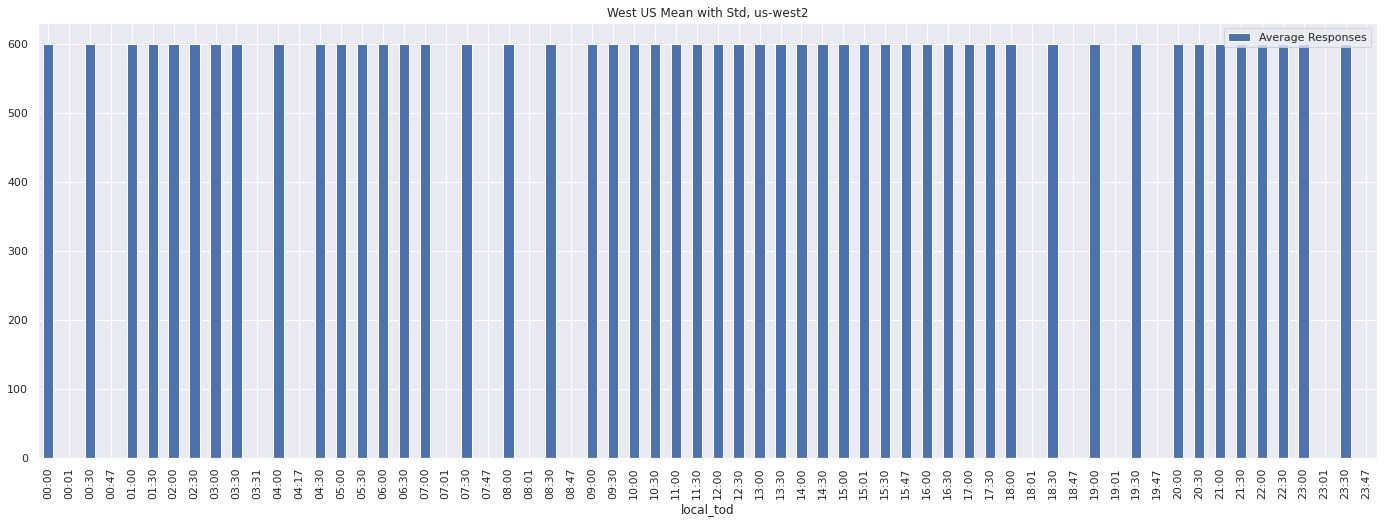

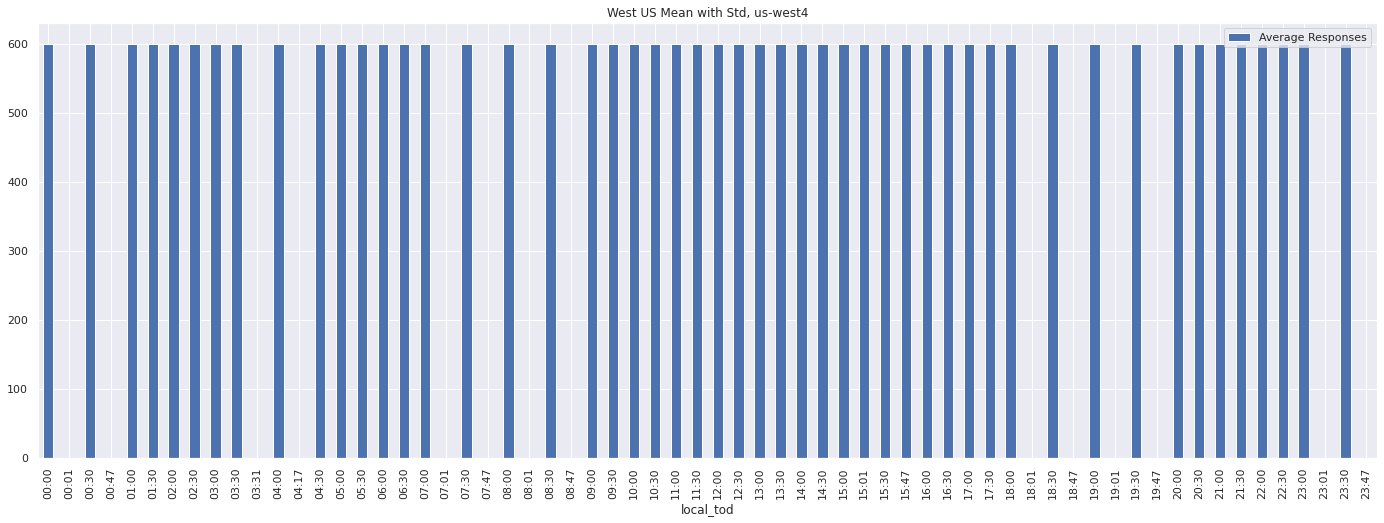

In [11]:
measure_group_region_df = dataset.groupby('measure_group')['region'].unique()
for mg in measure_group_region_df.index:
    regions = measure_group_region_df.loc[mg]
    for region in regions:
        fig, ax = plt.subplots(figsize=(24,8))
        df = avg_reponses_df[avg_reponses_df['region'] == region]
        df.plot(title=f'{mg} Mean with Std, {region}', kind='bar',  ax=ax)
        plt.show()
        plt.close()

In [15]:
dataset['driver_invocation'].dtype

dtype('<M8[ns]')

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(dataset, provider, region):
  df = dataset[ (dataset['provider'] == provider) & (dataset['region'] == region) ].groupby(['driver_invocation'])[['runtime']].mean()
  with plt.rc_context():
      plt.rc("figure", figsize=(20,8))
      result = seasonal_decompose(df, model='additive', freq=48)
      
      fig, axis = plt.subplots(figsize=(24,12), sharex=True, nrows=4)

      axis[0].plot(result.observed)
      plt.setp(axis[0], ylabel='Observed')

      axis[1].plot(result.resid)
      plt.setp(axis[1], ylabel='Residuals')

      axis[2].plot(result.trend)
      plt.setp(axis[2], ylabel='Trend')

      axis[3].plot(result.seasonal)
      plt.setp(axis[3], ylabel='Seasonal')

      hours = mdates.HourLocator(interval=12) #or use interval
      hours.MAXTICKS = 3392

      h_fmt = mdates.DateFormatter('%a %H')

      axis[0].xaxis.set_major_locator(hours)
      axis[0].xaxis.set_major_formatter(h_fmt)

      axis[1].xaxis.set_major_locator(hours)
      axis[1].xaxis.set_major_formatter(h_fmt)

      axis[2].xaxis.set_major_locator(hours)
      axis[2].xaxis.set_major_formatter(h_fmt)

      axis[3].xaxis.set_major_locator(hours)
      axis[3].xaxis.set_major_formatter(h_fmt)

      fig.autofmt_xdate()

      fig.suptitle(f"Decomposition for {provider} - {region}")

      plt.show()
      plt.close()

      return result

In [14]:
result = decompose(dataset, 'AZURE', 'japaneast')

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

In [ ]:
decompose(dataset, 'AZURE', 'japaneast')
decompose(dataset, 'GCP', 'asia-northeast1')
decompose(dataset, 'AWS', 'ap-northeast-1')

In [ ]:
decompose(dataset, 'AWS', 'us-west-1')
decompose(dataset, 'AWS', 'us-west-2')

In [ ]:
decompose(dataset, 'GCP', 'us-west2')
decompose(dataset, 'GCP', 'us-west4')